In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn keras tensorflow


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_validate,StratifiedKFold
from keras.layers import Dense
from keras.models import Sequential
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report,roc_auc_score
from keras.layers import Dropout
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.utils import to_categorical

In [3]:
data = pd.read_csv('data.csv')
data_cleaned = data.drop(columns=['patient_id','er_status_measured_by_ihc'])
data_cleaned.head()

C:\Users\ryana\AppData\Local\Temp\ipykernel_17248\4014827458.py:1: DtypeWarning: Columns (662,664,676,677,683,685,686,687) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data.csv')


,cancer_type,age_at_diagnosis,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status,neoplasm_histologic_grade,her2_status_measured_by_snp6,her2_status,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,Breast Invasive Ductal Carcinoma,54.29,High,1,LumB,1,Positive,3.0,NEUTRAL,Negative,...,0,0,0,0,0,0,0,0,0,0
1,Breast Invasive Ductal Carcinoma,43.45,Moderate,0,LumA,4,Positive,1.0,LOSS,Negative,...,0,0,0,0,0,0,0,0,0,0
2,Breast Invasive Ductal Carcinoma,74.11,High,0,LumB,3,Positive,3.0,NEUTRAL,Negative,...,0,0,0,0,0,0,0,0,0,0
3,Breast Invasive Ductal Carcinoma,51.87,High,0,LumA,3,Positive,2.0,NEUTRAL,Negative,...,0,0,0,0,0,0,0,0,0,0
4,Breast Invasive Ductal Carcinoma,87.18,Moderate,0,LumB,1,Positive,3.0,GAIN,Positive,...,0,0,0,0,0,0,0,0,0,0


In [4]:
def fill_missing_with_mode(data):
    # Get a list of columns with missing values
    columns_with_missing_values = data.columns[data.isnull().any()].tolist()
    
    # Iterate over each column with missing values
    for column_name in columns_with_missing_values:
        # Loop until no more null values in the column
        while data[column_name].isnull().any():
            # Iterate over rows in the DataFrame
            for i, row in data[data[column_name].isnull()].iterrows():
                # Filter the data for the same cancer type
                same_type_data = data[data['cancer_type'] == row['cancer_type']]
                
                # Try to find 5 other entries; if fewer, take as many as available
                if len(same_type_data) > 5:
                    sample = same_type_data.sample(n=5)
                else:
                    sample = same_type_data
                
                # Calculate the mode of the selected sample
                mode_value = sample[column_name].mode()
                
                # If mode calculation is successful and not empty, use the mode to fill the missing value
                if not mode_value.empty:
                    data.at[i, column_name] = mode_value.iloc[0]
                else:
                    # If no mode available (all values are different or no other samples), we might choose to do nothing or use a global mode
                    # Here we're choosing to use the global mode as a fallback
                    global_mode = data[column_name].mode()[0]
                    data.at[i, column_name] = global_mode

    return data

# Example usage for the column 'cellularity'
updated_data = fill_missing_with_mode(data_cleaned)

missing_values = updated_data.isnull().sum()
columns_with_missing_values = missing_values[missing_values > 0]

# Display columns with missing values and their counts
print(columns_with_missing_values)

Series([], dtype: int64)


In [5]:
X = data_cleaned.drop(columns=['cancer_type'])
y = data_cleaned['cancer_type']

cols_one_hot = [col for col in X.columns if X[col].dtype == 'object' and X[col].nunique() <= 5]
cols_label = [col for col in X.columns if X[col].dtype == 'object' and X[col].nunique() > 5]

# Initialize the transformers list for the ColumnTransformer
transformers = []

# Loop through each column in X to apply appropriate encoding
for column in X.columns:
    if X[column].dtype == 'object' or X[column].dtype == 'int':  # Adjusted to ensure we catch int types too
        X[column] = X[column].astype(str)  # Convert everything to string to avoid mixed type errors
        unique_values = X[column].nunique()
        if unique_values > 5:
            # Use LabelEncoder for columns with more than 5 unique values
            transformers.append((column, LabelEncoder(), [column]))  # LabelEncoder usage adjusted
        else:
            # Use OneHotEncoder for columns with 5 or fewer unique values
            transformers.append((column, OneHotEncoder(), [column]))

# Manually apply LabelEncoder to the relevant columns before ColumnTransformer
for name, encoder, columns in transformers:
    if isinstance(encoder, LabelEncoder):
        X[columns[0]] = encoder.fit_transform(X[columns[0]])  # Directly encode the column in the DataFrame
        # Remove label encoded columns from transformer list since they are already processed
        transformers = [(n, e, c) for n, e, c in transformers if e is not LabelEncoder]

# Setup remaining transformations with OneHotEncoder using ColumnTransformer
preprocessor_X = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), [name for name, encoder, _ in transformers if isinstance(encoder, OneHotEncoder)])
    ],
    remainder='passthrough'  # Keep all other columns that do not need encoding
)

# Fit and transform X with the defined ColumnTransformer for OneHotEncoder
X_transformed = preprocessor_X.fit_transform(X)

# Label encode y
label_encoder_y = LabelEncoder()
y_encoded = label_encoder_y.fit_transform(y)

# Print the final shape of X_transformed to verify feature count
print("Number of features in X after encoding:", X_transformed.shape[1])

Number of features in X after encoding: 734


In [6]:
from IPython.display import display
import pandas as pd

# Assume cols_label and cols_one_hot are defined and scoped correctly from a previous cell
onehot_features = preprocessor_X.named_transformers_['onehot'].get_feature_names_out()
label_features = cols_label  # Using the columns designated for label encoding
remainder_features = [col for col in X.columns if col not in cols_one_hot and col not in cols_label]

# Combining all feature names
all_features = list(onehot_features) + label_features + remainder_features

# Create the DataFrame from the transformed data
X_transformed_df = pd.DataFrame(X_transformed, columns=all_features[:X_transformed.shape[1]])

# Verify column counts and consistency
if len(all_features[:X_transformed.shape[1]]) != X_transformed_df.shape[1]:
    print(f"Warning: Column count mismatch. {len(all_features[:X_transformed.shape[1]])} names for {X_transformed_df.shape[1]} actual columns.")
else:
    print("Column names and counts are consistent.")

# Find the index of 'muc16_mut' column
muc16_mut_index = X_transformed_df.columns.get_loc("muc16_mut")

# Select columns after 'muc16_mut'
selected_columns = X_transformed_df.columns[muc16_mut_index + 1:]

# Display the selected columns for the first 30 rows of the DataFrame
display(X_transformed_df[selected_columns].head())


Column names and counts are consistent.


,ahnak2_mut,kmt2c_mut,syne1_mut,gata3_mut,map3k1_mut,ahnak_mut,dnah11_mut,cdh1_mut,dnah2_mut,kmt2d_mut,...,spry2,srd5a1,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17
0,3.0,1.0,3.0,2.0,5.160,111.100000,0.0,1.0,80.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,7.0,2.046,76.866667,1.0,1.0,23.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,1.0,6.0,3.0,6.056,118.700000,0.0,1.0,28.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,0.0,0.0,10.0,3.028,220.233333,1.0,1.0,14.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,1.0,2.0,1.0,5.052,28.600000,0.0,0.0,26.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
from sklearn.preprocessing import StandardScaler

start_index = X_transformed_df.columns.get_loc("brca1")
end_index = X_transformed_df.columns.get_loc("ugt2b17") +1

# Select the columns for scaling
columns_to_scale = X_transformed_df.columns[start_index:end_index]

# Initialize the StandardScaler
scaler = StandardScaler()

# Scale the selected columns
X_transformed_df[columns_to_scale] = scaler.fit_transform(X_transformed_df[columns_to_scale])

# Display the scaled data for these columns
print(X_transformed_df[columns_to_scale].head())

      brca1     brca2     palb2      pten      tp53       atm      cdh1  \
0 -1.211576 -0.109631 -0.594727 -1.140829  0.595648 -1.106277 -2.143642   
1  0.427194 -0.010864 -0.736981  0.064916  0.152814  0.097883  0.103718   
2 -0.477025 -0.151244 -0.772095 -0.847137  0.240765 -0.248629 -0.571054   
3 -0.548368  0.201905 -0.655579 -0.891006 -0.371917  1.477406  0.814926   
4  0.972271  0.990202 -0.241689  0.815784  0.212176  0.843807 -0.182637   

      chek2       nbn       nf1  ...     spry2    srd5a1    srd5a2    srd5a3  \
0 -1.105545 -0.703869 -0.394923  ... -0.057008 -0.069081 -0.062535 -0.065305   
1 -0.322918  0.518080 -0.696819  ... -0.057008 -0.069081 -0.062535 -0.065305   
2  0.063015  0.116458  0.202719  ... -0.057008 -0.069081 -0.062535 -0.065305   
3  0.903104  0.189407 -0.800239  ... -0.057008 -0.069081 -0.062535 -0.065305   
4 -0.134838 -0.517778  1.051354  ... -0.057008 -0.069081 -0.062535 -0.065305   

        st7      star      tnk2     tulp4   ugt2b15   ugt2b17  
0 -0

In [8]:
X_train, X_remaining, y_train, y_remaining = train_test_split(
    X_transformed_df, y_encoded, train_size=0.8, random_state=42, stratify=y_encoded
)

# Second split on the remaining 20% to get 10% Validation and 10% Test
X_valid, X_test, y_valid, y_test = train_test_split(
    X_remaining, y_remaining, test_size=0.5, random_state=42, stratify=y_remaining
)

# Print the sizes of each dataset to confirm the splits
print("Training set size:", X_train.shape, y_train.shape)
print("Validation set size:", X_valid.shape, y_valid.shape)
print("Test set size:", X_test.shape, y_test.shape)

Training set size: (1196, 734) (1196,)
Validation set size: (150, 734) (150,)
Test set size: (150, 734) (150,)


In [9]:
# Convert y_train to a pandas Series for easy counting
y_train_series = pd.Series(y_train)

# Get counts of each class
class_counts_train = y_train_series.value_counts()

# Print the counts with original class names using inverse transform of LabelEncoder
class_names_counts_train = pd.Series(class_counts_train.index).apply(
    lambda x: label_encoder_y.inverse_transform([x])[0])
class_counts_train.index = class_names_counts_train

# Display the class counts with names
print(class_counts_train)

# Class Number 0: Breast Invasive Ductal Carcinoma
# Class Number 1: Breast Invasive Lobular Carcinoma
# Class Number 2: Breast Invasive Mixed Mucinous Carcinoma
# Class Number 3: Breast Mixed Ductal and Lobular Carcinoma


Breast Invasive Ductal Carcinoma             959
Breast Mixed Ductal and Lobular Carcinoma    132
Breast Invasive Lobular Carcinoma             91
Breast Invasive Mixed Mucinous Carcinoma      14
Name: count, dtype: int64


In [10]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

In [11]:

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dropout, BatchNormalization
from keras.regularizers import l2

num_classes = len(np.unique(y_train))

model = Sequential([
    Dense(900, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(num_classes, activation='softmax')
])

# Instantiate the optimizer with the desired learning rate decay
initial_lr = 0.001
adam_optimizer = Adam(learning_rate=initial_lr)

# Compile the model with the customized optimizer
model.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


c:\Users\ryana\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(X_train, y_train, epochs=100, batch_size=512,
                    validation_data=(X_valid, y_valid),
                    class_weight=class_weight_dict,
                    callbacks=[early_stopping, reduce_lr])


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.2507 - loss: 1.9525 - val_accuracy: 0.2133 - val_loss: 2.2807 - learning_rate: 0.0010
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.2800 - loss: 1.4149 - val_accuracy: 0.2000 - val_loss: 2.4201 - learning_rate: 0.0010
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.3031 - loss: 1.1301 - val_accuracy: 0.1800 - val_loss: 3.0629 - learning_rate: 0.0010
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.3059 - loss: 1.2353 - val_accuracy: 0.1667 - val_loss: 4.0184 - learning_rate: 0.0010
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.3491 - loss: 1.0473 - val_accuracy: 0.2200 - val_loss: 3.2347 - learning_rate: 0.0010
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.3503 - loss: 0.9698 - val_accuracy: 0.3067 - val_loss: 2.1046 - learning_rate: 0.0010
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.3941 - loss: 0.9470 - val_accur

In [13]:
# import matplotlib.pyplot as plt

# # Summarize history for accuracy
# plt.figure(figsize=(10, 5))
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(loc='upper left')
# plt.show()

# # Summarize history for loss
# plt.figure(figsize=(10, 5))
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(loc='upper right')
# plt.show()


In [14]:
y_pred = model.predict(X_valid)

# Convert the predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Generate the classification report
report = classification_report(y_valid, y_pred_labels)

# Print the classification report
print(report)

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 302ms/step
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       120
           1       0.22      0.18      0.20        11
           2       0.00      0.00      0.00         2
           3       0.25      0.06      0.10        17

    accuracy                           0.77       150
   macro avg       0.32      0.29      0.29       150
weighted avg       0.70      0.77      0.72       150



c:\Users\ryana\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ryana\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ryana\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
pip install imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


In [16]:
from imblearn.under_sampling import RandomUnderSampler
import numpy as np

# Assuming y_train contains the class labels, and X_train contains the features

# Setup the RandomUnderSampler to reduce class 0 to 500 instances
rus = RandomUnderSampler(sampling_strategy={0: 500})

# Apply the resampling to the training data
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Check the new class distribution to ensure it is as expected
print("New class distribution:", np.bincount(y_resampled))

# Now X_resampled and y_resampled contain the undersampled data where class 0 has exactly 500 instances

New class distribution: [500  91  14 132]


In [17]:
y_train_binary = (y_train == 0).astype(int)  # 1 for 'Breast Invasive Ductal Carcinoma', 0 otherwise
y_valid_binary = (y_valid == 0).astype(int)

from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.regularizers import l2

# Define class weights for balancing
class_weights = {
    0: 7,  # for 'Other Classes'
    1: 1   # for 'Breast Invasive Ductal Carcinoma'
}

# Model construction with simplified architecture
model = Sequential([
    Dense(250, activation='relu'),
    Dropout(0.2),# Reduced number of neurons
    Dense(100, activation='relu'),
    Dense(50, activation='relu'),
    Dense(20, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

adam_optimizer = Adam(learning_rate=0.001)


model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Training the model with adjusted parameters
history = model.fit(X_train, y_train_binary, epochs=100, batch_size=200,  # Increased epochs, reduced batch size
                    validation_data=(X_valid, y_valid_binary),
                    class_weight=class_weights)


Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 303ms/step - accuracy: 0.3878 - loss: 1.9330 - val_accuracy: 0.2133 - val_loss: 1.0600
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.3328 - loss: 1.5373 - val_accuracy: 0.6667 - val_loss: 0.6274
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.4430 - loss: 1.4366 - val_accuracy: 0.5200 - val_loss: 0.7504
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.5396 - loss: 1.2915 - val_accuracy: 0.5400 - val_loss: 0.7746
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.4799 - loss: 1.2751 - val_accuracy: 0.5867 - val_loss: 0.6737
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.5958 - loss: 1.2075 - val_accuracy: 0.5667 - val_loss: 0.6687
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.5980 - loss: 1.1648 - val_accuracy: 0.5600 - val_loss: 0.7117
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.5973 - loss: 1.1227 - val_accuracy: 0.6267 - val_los

In [18]:
# Assuming 'model' and 'X_valid' are already defined and model is trained

# Predict the probabilities for the validation set
y_pred_probs = model.predict(X_valid)

# Convert probabilities to binary predictions with a threshold of 0.5
y_pred_binary = (y_pred_probs > 0.5).astype(int)

# Generate and print the classification report
report = classification_report(y_valid_binary, y_pred_binary, target_names=['Other Classes', 'Breast Invasive Ductal Carcinoma'])
print("Classification Report:\n", report)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
Classification Report:
                                   precision    recall  f1-score   support

                   Other Classes       0.41      0.43      0.42        30
Breast Invasive Ductal Carcinoma       0.86      0.84      0.85       120

                        accuracy                           0.76       150
                       macro avg       0.63      0.64      0.63       150
                    weighted avg       0.77      0.76      0.76       150



In [19]:
# Assuming y_train and y_valid contain class labels
# Let's say 'Class 1' is the new focus, adapt y_train_binary and y_valid_binary accordingly
y_train_binary = (y_resampled == 1).astype(int)  # 1 for 'Class 1', 0 for others
y_valid_binary = (y_valid == 1).astype(int)

# Update class weights if needed
class_weight_dict = {
    0: 1,       # Normal weight for 'Other Classes'
    1: 6       # Increased weight for 'Class 1'
}
input_shape = X_train.shape[1]  # Number of input features

# Construct a new model architecture
model_class_1 = Sequential([
    Dense(250, activation='relu', input_shape=(input_shape,)),
    Dropout(0.3),
    Dense(156, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Set the learning rate
learning_rate = 0.001

# Instantiate the optimizer with the desired learning rate
adam_optimizer = Adam(learning_rate=learning_rate)

# Compile the model with the customized optimizer
model_class_1.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the new model
history_class_1 = model_class_1.fit(X_resampled, y_train_binary, epochs=100, batch_size=50,
                                    validation_data=(X_valid, y_valid_binary),
                                    class_weight=class_weight_dict)

c:\Users\ryana\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.5035 - loss: 4.5473 - val_accuracy: 0.7600 - val_loss: 0.4997
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5919 - loss: 1.6545 - val_accuracy: 0.6800 - val_loss: 0.5546
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6137 - loss: 1.4960 - val_accuracy: 0.7400 - val_loss: 0.5507
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7342 - loss: 1.2151 - val_accuracy: 0.5800 - val_loss: 0.7362
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7353 - loss: 1.1273 - val_accuracy: 0.8133 - val_loss: 0.4315
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7197 - loss: 1.1451 - val_accuracy: 0.9067 - val_loss: 0.2951
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8049 - loss: 0.8670 - val_accuracy: 0.8533 - val_loss: 0.3919
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8812 - loss: 0.7355 - val_accuracy: 

In [20]:
# Predict the probabilities for the validation set
y_pred_probs_class_1 = model_class_1.predict(X_valid)

# Convert probabilities to binary predictions with a threshold of 0.5
y_pred_binary_class_1 = (y_pred_probs_class_1 > 0.5).astype(int)

# Generate and print the classification report
report_class_1 = classification_report(y_valid_binary, y_pred_binary_class_1, 
                                       target_names=['Other Classes', 'Class 1'])
print("Classification Report for Class 1:\n", report_class_1)


1/5 ━━━━━━━━━━━━━━━━━━━━ 2s 531ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000023FE29A9EE0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
Classification Report for Class 1:
                precision    recall  f1-score   support

Other Classes       0.96      0.94      0.95       139
      Class 1       0.36      0.45      0.40      

In [21]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Assuming y_train and y_valid contain class labels

# Binarize y_train and y_valid so that 'Class 3' is 1 and all other classes are 0
y_train_binary = (y_train == 3).astype(int)  # 1 for 'Class 3', 0 for others
y_valid_binary = (y_valid == 3).astype(int)

# Balancing the dataset with a combination of SMOTE and RandomUnderSampler
smote = SMOTE(sampling_strategy={1: 300})  # Upsampling 'Class 3' to 300 instances
under = RandomUnderSampler(sampling_strategy={0: 500})  # Downsampling 'Other Classes' to 500 instances
pipeline = Pipeline([('smote', smote), ('under', under)])
X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train_binary)

# Recalculate class weights after resampling
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_resampled),
    y=y_resampled
)
class_weight_dict = dict(enumerate(class_weights))

# Redesigning the neural network model
model = Sequential([
    Dense(256, activation='relu', input_dim=X_resampled.shape[1]),
    Dropout(0.4),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model with Adam optimizer and a lower learning rate for better convergence
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Training the model with adjusted batch size and epochs
history = model.fit(
    X_resampled, y_resampled,
    epochs=120,  # Increasing the number of epochs to allow better learning
    batch_size=50,  # Smaller batch size for more frequent updates
    validation_data=(X_valid, y_valid_binary),
    class_weight=class_weight_dict
)

# Evaluating the model's performance on the validation data
val_accuracy = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]
print(f"Validation Accuracy: {val_accuracy:.2f}, Validation Loss: {val_loss:.2f}")

c:\Users\ryana\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - accuracy: 0.5410 - loss: 0.7112 - val_accuracy: 0.7133 - val_loss: 0.6331
Epoch 2/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5214 - loss: 0.7210 - val_accuracy: 0.6333 - val_loss: 0.6630
Epoch 3/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5608 - loss: 0.7193 - val_accuracy: 0.5467 - val_loss: 0.6794
Epoch 4/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5381 - loss: 0.6716 - val_accuracy: 0.5067 - val_loss: 0.6873
Epoch 5/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5381 - loss: 0.6974 - val_accuracy: 0.5133 - val_loss: 0.6885
Epoch 6/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5548 - loss: 0.6849 - val_accuracy: 0.5200 - val_loss: 0.6832
Epoch 7/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5749 - loss: 0.6705 - val_accuracy: 0.4933 - val_loss: 0.6817
Epoch 8/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5789 - loss: 0.6721 - val_accuracy: 

In [22]:
y_pred_probs = model.predict(X_valid)

# Convert probabilities to binary predictions with a threshold of 0.5
y_pred_binary = (y_pred_probs > 0.5).astype(int)

# Generating the classification report
from sklearn.metrics import classification_report
report = classification_report(y_valid_binary, y_pred_binary, target_names=['Other Classes', 'Class 3'])
print("Classification Report for Class 3:\n", report)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step
Classification Report for Class 3:
                precision    recall  f1-score   support

Other Classes       0.89      0.80      0.85       133
      Class 3       0.13      0.24      0.17        17

     accuracy                           0.74       150
    macro avg       0.51      0.52      0.51       150
 weighted avg       0.81      0.74      0.77       150



In [23]:
pip install pandas numpy matplotlib seaborn scikit-learn keras tensorflow


Note: you may need to restart the kernel to use updated packages.


In [24]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_validate,StratifiedKFold
from keras.layers import Dense
from keras.models import Sequential
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report,roc_auc_score
from keras.layers import Dropout
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.utils import to_categorical

In [25]:
data = pd.read_csv('data.csv')
data_cleaned = data.drop(columns=['patient_id','er_status_measured_by_ihc'])
data_cleaned.head()

C:\Users\ryana\AppData\Local\Temp\ipykernel_17248\4014827458.py:1: DtypeWarning: Columns (662,664,676,677,683,685,686,687) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data.csv')


,cancer_type,age_at_diagnosis,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status,neoplasm_histologic_grade,her2_status_measured_by_snp6,her2_status,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,Breast Invasive Ductal Carcinoma,54.29,High,1,LumB,1,Positive,3.0,NEUTRAL,Negative,...,0,0,0,0,0,0,0,0,0,0
1,Breast Invasive Ductal Carcinoma,43.45,Moderate,0,LumA,4,Positive,1.0,LOSS,Negative,...,0,0,0,0,0,0,0,0,0,0
2,Breast Invasive Ductal Carcinoma,74.11,High,0,LumB,3,Positive,3.0,NEUTRAL,Negative,...,0,0,0,0,0,0,0,0,0,0
3,Breast Invasive Ductal Carcinoma,51.87,High,0,LumA,3,Positive,2.0,NEUTRAL,Negative,...,0,0,0,0,0,0,0,0,0,0
4,Breast Invasive Ductal Carcinoma,87.18,Moderate,0,LumB,1,Positive,3.0,GAIN,Positive,...,0,0,0,0,0,0,0,0,0,0


In [26]:
def fill_missing_with_mode(data):
    # Get a list of columns with missing values
    columns_with_missing_values = data.columns[data.isnull().any()].tolist()
    
    # Iterate over each column with missing values
    for column_name in columns_with_missing_values:
        # Loop until no more null values in the column
        while data[column_name].isnull().any():
            # Iterate over rows in the DataFrame
            for i, row in data[data[column_name].isnull()].iterrows():
                # Filter the data for the same cancer type
                same_type_data = data[data['cancer_type'] == row['cancer_type']]
                
                # Try to find 5 other entries; if fewer, take as many as available
                if len(same_type_data) > 5:
                    sample = same_type_data.sample(n=5)
                else:
                    sample = same_type_data
                
                # Calculate the mode of the selected sample
                mode_value = sample[column_name].mode()
                
                # If mode calculation is successful and not empty, use the mode to fill the missing value
                if not mode_value.empty:
                    data.at[i, column_name] = mode_value.iloc[0]
                else:
                    # If no mode available (all values are different or no other samples), we might choose to do nothing or use a global mode
                    # Here we're choosing to use the global mode as a fallback
                    global_mode = data[column_name].mode()[0]
                    data.at[i, column_name] = global_mode

    return data

# Example usage for the column 'cellularity'
updated_data = fill_missing_with_mode(data_cleaned)

missing_values = updated_data.isnull().sum()
columns_with_missing_values = missing_values[missing_values > 0]

# Display columns with missing values and their counts
print(columns_with_missing_values)

Series([], dtype: int64)


In [27]:
X = data_cleaned.drop(columns=['cancer_type'])
y = data_cleaned['cancer_type']

cols_one_hot = [col for col in X.columns if X[col].dtype == 'object' and X[col].nunique() <= 5]
cols_label = [col for col in X.columns if X[col].dtype == 'object' and X[col].nunique() > 5]

# Initialize the transformers list for the ColumnTransformer
transformers = []

# Loop through each column in X to apply appropriate encoding
for column in X.columns:
    if X[column].dtype == 'object' or X[column].dtype == 'int':  # Adjusted to ensure we catch int types too
        X[column] = X[column].astype(str)  # Convert everything to string to avoid mixed type errors
        unique_values = X[column].nunique()
        if unique_values > 5:
            # Use LabelEncoder for columns with more than 5 unique values
            transformers.append((column, LabelEncoder(), [column]))  # LabelEncoder usage adjusted
        else:
            # Use OneHotEncoder for columns with 5 or fewer unique values
            transformers.append((column, OneHotEncoder(), [column]))

# Manually apply LabelEncoder to the relevant columns before ColumnTransformer
for name, encoder, columns in transformers:
    if isinstance(encoder, LabelEncoder):
        X[columns[0]] = encoder.fit_transform(X[columns[0]])  # Directly encode the column in the DataFrame
        # Remove label encoded columns from transformer list since they are already processed
        transformers = [(n, e, c) for n, e, c in transformers if e is not LabelEncoder]

# Setup remaining transformations with OneHotEncoder using ColumnTransformer
preprocessor_X = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), [name for name, encoder, _ in transformers if isinstance(encoder, OneHotEncoder)])
    ],
    remainder='passthrough'  # Keep all other columns that do not need encoding
)

# Fit and transform X with the defined ColumnTransformer for OneHotEncoder
X_transformed = preprocessor_X.fit_transform(X)

# Label encode y
label_encoder_y = LabelEncoder()
y_encoded = label_encoder_y.fit_transform(y)

# Print the final shape of X_transformed to verify feature count
print("Number of features in X after encoding:", X_transformed.shape[1])

Number of features in X after encoding: 734


In [28]:
from IPython.display import display
import pandas as pd

# Assume cols_label and cols_one_hot are defined and scoped correctly from a previous cell
onehot_features = preprocessor_X.named_transformers_['onehot'].get_feature_names_out()
label_features = cols_label  # Using the columns designated for label encoding
remainder_features = [col for col in X.columns if col not in cols_one_hot and col not in cols_label]

# Combining all feature names
all_features = list(onehot_features) + label_features + remainder_features

# Create the DataFrame from the transformed data
X_transformed_df = pd.DataFrame(X_transformed, columns=all_features[:X_transformed.shape[1]])

# Verify column counts and consistency
if len(all_features[:X_transformed.shape[1]]) != X_transformed_df.shape[1]:
    print(f"Warning: Column count mismatch. {len(all_features[:X_transformed.shape[1]])} names for {X_transformed_df.shape[1]} actual columns.")
else:
    print("Column names and counts are consistent.")

# Find the index of 'muc16_mut' column
muc16_mut_index = X_transformed_df.columns.get_loc("muc16_mut")

# Select columns after 'muc16_mut'
selected_columns = X_transformed_df.columns[muc16_mut_index + 1:]

# Display the selected columns for the first 30 rows of the DataFrame
display(X_transformed_df[selected_columns].head())


Column names and counts are consistent.


,ahnak2_mut,kmt2c_mut,syne1_mut,gata3_mut,map3k1_mut,ahnak_mut,dnah11_mut,cdh1_mut,dnah2_mut,kmt2d_mut,...,spry2,srd5a1,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17
0,3.0,1.0,3.0,2.0,5.160,111.100000,0.0,1.0,80.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,7.0,2.046,76.866667,1.0,1.0,23.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,1.0,6.0,3.0,6.056,118.700000,0.0,1.0,28.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,0.0,0.0,10.0,3.028,220.233333,1.0,1.0,14.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,1.0,2.0,1.0,5.052,28.600000,0.0,0.0,26.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
from sklearn.preprocessing import StandardScaler

start_index = X_transformed_df.columns.get_loc("brca1")
end_index = X_transformed_df.columns.get_loc("ugt2b17") +1

# Select the columns for scaling
columns_to_scale = X_transformed_df.columns[start_index:end_index]

# Initialize the StandardScaler
scaler = StandardScaler()

# Scale the selected columns
X_transformed_df[columns_to_scale] = scaler.fit_transform(X_transformed_df[columns_to_scale])

# Display the scaled data for these columns
print(X_transformed_df[columns_to_scale].head())

      brca1     brca2     palb2      pten      tp53       atm      cdh1  \
0 -1.211576 -0.109631 -0.594727 -1.140829  0.595648 -1.106277 -2.143642   
1  0.427194 -0.010864 -0.736981  0.064916  0.152814  0.097883  0.103718   
2 -0.477025 -0.151244 -0.772095 -0.847137  0.240765 -0.248629 -0.571054   
3 -0.548368  0.201905 -0.655579 -0.891006 -0.371917  1.477406  0.814926   
4  0.972271  0.990202 -0.241689  0.815784  0.212176  0.843807 -0.182637   

      chek2       nbn       nf1  ...     spry2    srd5a1    srd5a2    srd5a3  \
0 -1.105545 -0.703869 -0.394923  ... -0.057008 -0.069081 -0.062535 -0.065305   
1 -0.322918  0.518080 -0.696819  ... -0.057008 -0.069081 -0.062535 -0.065305   
2  0.063015  0.116458  0.202719  ... -0.057008 -0.069081 -0.062535 -0.065305   
3  0.903104  0.189407 -0.800239  ... -0.057008 -0.069081 -0.062535 -0.065305   
4 -0.134838 -0.517778  1.051354  ... -0.057008 -0.069081 -0.062535 -0.065305   

        st7      star      tnk2     tulp4   ugt2b15   ugt2b17  
0 -0

In [30]:

# X_transformed_df
# y_encoded

X_train, X_remaining, y_train, y_remaining = train_test_split(
    X_transformed_df, y_encoded, train_size=0.8, random_state=42, stratify=y_encoded
)

X_train = 

# Second split on the remaining 20% to get 10% Validation and 10% Test
X_valid, X_test, y_valid, y_test = train_test_split(
    X_remaining, y_remaining, test_size=0.5, random_state=42, stratify=y_remaining
)

# X_train
# y_train
# X_valid
# y_valid
# X_test
# y_test

# Print the sizes of each dataset to confirm the splits
print("Training set size:", X_train.shape, y_train.shape)
print("Validation set size:", X_valid.shape, y_valid.shape)
print("Test set size:", X_test.shape, y_test.shape)

Training set size: (1196, 734) (1196,)
Validation set size: (150, 734) (150,)
Test set size: (150, 734) (150,)


In [31]:
# Convert y_train to a pandas Series for easy counting
y_train_series = pd.Series(y_train)

# Get counts of each class
class_counts_train = y_train_series.value_counts()

# Print the counts with original class names using inverse transform of LabelEncoder
class_names_counts_train = pd.Series(class_counts_train.index).apply(
    lambda x: label_encoder_y.inverse_transform([x])[0])
class_counts_train.index = class_names_counts_train

# Display the class counts with names
print(class_counts_train)

# Class Number 0: Breast Invasive Ductal Carcinoma
# Class Number 1: Breast Invasive Lobular Carcinoma
# Class Number 2: Breast Invasive Mixed Mucinous Carcinoma
# Class Number 3: Breast Mixed Ductal and Lobular Carcinoma


Breast Invasive Ductal Carcinoma             959
Breast Mixed Ductal and Lobular Carcinoma    132
Breast Invasive Lobular Carcinoma             91
Breast Invasive Mixed Mucinous Carcinoma      14
Name: count, dtype: int64


In [32]:
# from sklearn.utils.class_weight import compute_class_weight
# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(y_train),
#     y=y_train
# )
# class_weight_dict = dict(enumerate(class_weights))

In [33]:
# from keras.optimizers import Adam
# from keras.callbacks import EarlyStopping
# from keras.layers import Dropout
# from keras.regularizers import l2
# from keras.layers import BatchNormalization
# num_classes = len(np.unique(y_train))

# model = Sequential([
#     Dense(900, activation='relu', input_shape=(X_train.shape[1],)),
#     Dropout(0.2),
#     Dense(512, activation='relu'),
#     Dropout(0.2),
#     Dense(256, activation='relu'),
#     Dropout(0.2),
#     Dense(128, activation='relu'),
#     Dense(64, activation='relu'),
#     Dense(num_classes, activation='softmax')
# ])

# # Set the learning rate
# learning_rate = 0.01  # You can change this value according to your needs

# # Instantiate the optimizer with the desired learning rate
# adam_optimizer = Adam(learning_rate=learning_rate)

# # Compile the model with the customized optimizer
# model.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [34]:
# history = model.fit(X_train, y_train, epochs=100, batch_size=600,
#                     validation_data=(X_valid, y_valid),
#                     class_weight=class_weight_dict)

In [35]:
# import matplotlib.pyplot as plt

# # Summarize history for accuracy
# plt.figure(figsize=(10, 5))
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(loc='upper left')
# plt.show()

# # Summarize history for loss
# plt.figure(figsize=(10, 5))
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(loc='upper right')
# plt.show()


In [36]:
# y_pred = model.predict(X_valid)

# # Convert the predicted probabilities to class labels
# y_pred_labels = np.argmax(y_pred, axis=1)

# # Generate the classification report
# report = classification_report(y_valid, y_pred_labels)

# # Print the classification report
# print(report)

In [37]:
pip install imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


In [38]:
from imblearn.under_sampling import RandomUnderSampler
import numpy as np

# Assuming y_train contains the class labels, and X_train contains the features

# Setup the RandomUnderSampler to reduce class 0 to 500 instances
rus = RandomUnderSampler(sampling_strategy={0: 500})

# Apply the resampling to the training data
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Check the new class distribution to ensure it is as expected
print("New class distribution:", np.bincount(y_resampled))

# Now X_resampled and y_resampled contain the undersampled data where class 0 has exactly 500 instances

New class distribution: [500  91  14 132]


In [39]:
y_train_binary = (y_train == 0).astype(int)  # 1 for 'Breast Invasive Ductal Carcinoma', 0 otherwise
y_valid_binary = (y_valid == 0).astype(int)

from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.regularizers import l2

# Define class weights for balancing
class_weights = {
    0: 7,  # for 'Other Classes'
    1: 1   # for 'Breast Invasive Ductal Carcinoma'
}

# Model construction with simplified architecture
model_class_0 = Sequential([
    Dense(250, activation='relu'),
    Dropout(0.2),# Reduced number of neurons
    Dense(100, activation='relu'),
    Dense(50, activation='relu'),
    Dense(20, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

adam_optimizer = Adam(learning_rate=0.001)


model_class_0.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Training the model with adjusted parameters
history = model_class_0.fit(X_train, y_train_binary, epochs=100, batch_size=200,  # Increased epochs, reduced batch size
                    validation_data=(X_valid, y_valid_binary),
                    class_weight=class_weights)


Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 298ms/step - accuracy: 0.4756 - loss: 2.5297 - val_accuracy: 0.3267 - val_loss: 0.9448
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.5170 - loss: 1.6345 - val_accuracy: 0.2733 - val_loss: 1.2464
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.3614 - loss: 1.5842 - val_accuracy: 0.6267 - val_loss: 0.6310
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.6472 - loss: 1.2906 - val_accuracy: 0.2933 - val_loss: 1.2015
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.4528 - loss: 1.3142 - val_accuracy: 0.5200 - val_loss: 0.6827
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.6214 - loss: 1.1631 - val_accuracy: 0.4933 - val_loss: 0.8154
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.5885 - loss: 1.1376 - val_accuracy: 0.5933 - val_loss: 0.6576
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.6651 - loss: 1.0241 - val_accuracy: 0.5200 - val_los

In [40]:
# Assuming 'model' and 'X_valid' are already defined and model is trained

# Predict the probabilities for the validation set
y_pred_probs = model_class_0.predict(X_valid)

# Convert probabilities to binary predictions with a threshold of 0.5
y_pred_binary = (y_pred_probs > 0.5).astype(int)

# Generate and print the classification report
report = classification_report(y_valid_binary, y_pred_binary, target_names=['Other Classes', 'Breast Invasive Ductal Carcinoma'])
print("Classification Report:\n", report)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
Classification Report:
                                   precision    recall  f1-score   support

                   Other Classes       0.31      0.37      0.33        30
Breast Invasive Ductal Carcinoma       0.83      0.79      0.81       120

                        accuracy                           0.71       150
                       macro avg       0.57      0.58      0.57       150
                    weighted avg       0.73      0.71      0.72       150



In [41]:
# Assuming y_train and y_valid contain class labels
# Let's say 'Class 1' is the new focus, adapt y_train_binary and y_valid_binary accordingly
y_train_binary = (y_resampled == 1).astype(int)  # 1 for 'Class 1', 0 for others
y_valid_binary = (y_valid == 1).astype(int)

# Update class weights if needed
class_weight_dict = {
    0: 1,       # Normal weight for 'Other Classes'
    1: 6       # Increased weight for 'Class 1'
}
input_shape = X_train.shape[1]  # Number of input features

# Construct a new model architecture
model_class_1 = Sequential([
    Dense(250, activation='relu', input_shape=(input_shape,)),
    Dropout(0.3),
    Dense(156, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Set the learning rate
learning_rate = 0.001

# Instantiate the optimizer with the desired learning rate
adam_optimizer = Adam(learning_rate=learning_rate)

# Compile the model with the customized optimizer
model_class_1.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the new model
history_class_1 = model_class_1.fit(X_resampled, y_train_binary, epochs=100, batch_size=50,
                                    validation_data=(X_valid, y_valid_binary),
                                    class_weight=class_weight_dict)

c:\Users\ryana\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - accuracy: 0.6143 - loss: 2.9692 - val_accuracy: 0.8867 - val_loss: 0.4234
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6407 - loss: 1.2917 - val_accuracy: 0.6267 - val_loss: 0.6668
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5845 - loss: 1.2977 - val_accuracy: 0.8667 - val_loss: 0.4755
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7225 - loss: 1.0495 - val_accuracy: 0.7800 - val_loss: 0.5764
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6972 - loss: 1.0482 - val_accuracy: 0.8067 - val_loss: 0.5072
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7333 - loss: 0.9423 - val_accuracy: 0.7600 - val_loss: 0.5254
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7633 - loss: 0.8765 - val_accuracy: 0.8533 - val_loss: 0.4123
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7797 - loss: 0.7097 - val_accuracy: 

In [42]:
# Predict the probabilities for the validation set
y_pred_probs_class_1 = model_class_1.predict(X_valid)

# Convert probabilities to binary predictions with a threshold of 0.5
y_pred_binary_class_1 = (y_pred_probs_class_1 > 0.5).astype(int)

# Generate and print the classification report
report_class_1 = classification_report(y_valid_binary, y_pred_binary_class_1, 
                                       target_names=['Other Classes', 'Class 1'])
print("Classification Report for Class 1:\n", report_class_1)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
Classification Report for Class 1:
                precision    recall  f1-score   support

Other Classes       0.96      0.95      0.95       139
      Class 1       0.42      0.45      0.43        11

     accuracy                           0.91       150
    macro avg       0.69      0.70      0.69       150
 weighted avg       0.92      0.91      0.92       150



In [43]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Assuming y_train and y_valid contain class labels

# Binarize y_train and y_valid so that 'Class 3' is 1 and all other classes are 0
y_train_binary = (y_train == 3).astype(int)  # 1 for 'Class 3', 0 for others
y_valid_binary = (y_valid == 3).astype(int)

# Balancing the dataset with a combination of SMOTE and RandomUnderSampler
smote = SMOTE(sampling_strategy={1: 300})  # Upsampling 'Class 3' to 300 instances
under = RandomUnderSampler(sampling_strategy={0: 500})  # Downsampling 'Other Classes' to 500 instances
pipeline = Pipeline([('smote', smote), ('under', under)])
X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train_binary)

# Recalculate class weights after resampling
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_resampled),
    y=y_resampled
)
class_weight_dict = dict(enumerate(class_weights))

# Redesigning the neural network model
model_class_3 = Sequential([
    Dense(256, activation='relu', input_dim=X_resampled.shape[1]),
    Dropout(0.4),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model with Adam optimizer and a lower learning rate for better convergence
model_class_3.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Training the model with adjusted batch size and epochs
history = model_class_3.fit(
    X_resampled, y_resampled,
    epochs=120,  # Increasing the number of epochs to allow better learning
    batch_size=50,  # Smaller batch size for more frequent updates
    validation_data=(X_valid, y_valid_binary),
    class_weight=class_weight_dict
)

# Evaluating the model's performance on the validation data
val_accuracy = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]
print(f"Validation Accuracy: {val_accuracy:.2f}, Validation Loss: {val_loss:.2f}")

c:\Users\ryana\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step - accuracy: 0.4292 - loss: 0.7957 - val_accuracy: 0.2000 - val_loss: 0.9261
Epoch 2/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4376 - loss: 0.7380 - val_accuracy: 0.2533 - val_loss: 0.8348
Epoch 3/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4563 - loss: 0.7398 - val_accuracy: 0.3533 - val_loss: 0.7692
Epoch 4/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4859 - loss: 0.7351 - val_accuracy: 0.4133 - val_loss: 0.7374
Epoch 5/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4806 - loss: 0.7125 - val_accuracy: 0.4867 - val_loss: 0.7135
Epoch 6/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4918 - loss: 0.7133 - val_accuracy: 0.5267 - val_loss: 0.6960
Epoch 7/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5178 - loss: 0.6756 - val_accuracy: 0.5733 - val_loss: 0.6822
Epoch 8/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5537 - loss: 0.6860 - val_accuracy: 

In [44]:
y_pred_probs = model_class_3.predict(X_valid)

# Convert probabilities to binary predictions with a threshold of 0.5
y_pred_binary = (y_pred_probs > 0.5).astype(int)

# Generating the classification report
from sklearn.metrics import classification_report
report = classification_report(y_valid_binary, y_pred_binary, target_names=['Other Classes', 'Class 3'])
print("Classification Report for Class 3:\n", report)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step
Classification Report for Class 3:
                precision    recall  f1-score   support

Other Classes       0.91      0.82      0.86       133
      Class 3       0.20      0.35      0.26        17

     accuracy                           0.77       150
    macro avg       0.55      0.59      0.56       150
 weighted avg       0.83      0.77      0.79       150



In [56]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

def predict_with_customization(X_test, y_test, model_0, model_1, model_3):
    # Initialize an empty list to hold all predicted classes
    predictions = []

    # Convert test data to TensorFlow tensors and reshape
    X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
    X_test = tf.reshape(X_test, [-1, 734])  # Adjust to the correct feature size

    for i in range(X_test.shape[0]):
        try:
            example = X_test[i]
            example = tf.expand_dims(example, axis=0)

            # Predict using all three models
            pred_0 = model_0.predict(example)[0, 0]
            pred_1 = model_1.predict(example)[0, 0]
            pred_3 = model_3.predict(example)[0, 0]

            # Determine all predicted classes
            predicted_classes = determine_predicted_classes(pred_0, pred_1, pred_3)

            # Assume the first class in the list as the primary class (or default to 2)
            primary_class = predicted_classes[0]
            predictions.append(primary_class)

        except Exception as e:
            print(f"Error processing example {i}: {e}")
            predictions.append(2)  # Fallback to class 2 on error

    # Convert predictions to a numpy array
    predictions = np.array(predictions)

    # Generate classification report
    print("\nClassification Report:")
    report = classification_report(y_test, predictions, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
    print(report)

    # Generate confusion matrix
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, predictions)
    print(cm)

    # Optionally, you can also visualize the confusion matrix using matplotlib
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'],
                yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

def determine_predicted_classes(pred_0, pred_1, pred_3):
    # Return a list of classes that meet or exceed the threshold of 0.5
    predicted_classes = []
    if pred_0 >= 0.5:
        predicted_classes.append(0)
    if pred_1 >= 0.5:
        predicted_classes.append(1)
    if pred_3 >= 0.5:
        predicted_classes.append(3)
    # If no classes were predicted, default to class 2
    if not predicted_classes:
        predicted_classes.append(2)
    return predicted_classes


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

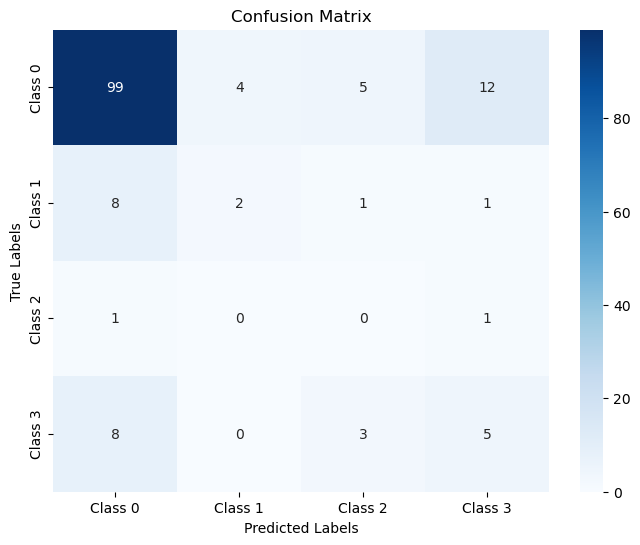

In [57]:
predict_with_customization(X_test, y_test, model_class_0, model_class_1, model_class_3)
